In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sktime.classification.kernel_based import RocketClassifier

import keras
from keras import layers
from keras import callbacks
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

In [2]:
df = pd.read_json('clean.json')

to_drop = df[df['target'].isin(["Mal", "Niño", "Abrir", "Zapato"])].index
df.drop(to_drop, axis='rows', inplace=True)

encoder = OneHotEncoder()
encoded = encoder.fit_transform(df[['target']])
new_cols = pd.DataFrame(encoded.toarray(), columns=encoder.categories_)

df.reset_index(drop=True, inplace=True)
df = pd.concat([new_cols, df], axis='columns')

# df.drop(columns=['target'], inplace=True)

cols = []
for col in df.columns:
    cols.append(str(col).replace("('", "").replace("',)", ""))

df.columns = cols

print(df.shape)
df.head()

(101, 5)


,Avión,Borrar,Encender,target,norm
0,0.0,1.0,0.0,Borrar,"{'Left_0_x': {'0': 0.3712333739, '1': 0.371233..."
1,0.0,1.0,0.0,Borrar,"{'Left_0_x': {'0': 0.7903555036000001, '1': 0...."
2,0.0,1.0,0.0,Borrar,"{'Left_0_x': {'0': 0.8096246123, '1': 0.809624..."
3,0.0,1.0,0.0,Borrar,"{'Left_0_x': {'0': 0.7502717972, '1': 0.750271..."
4,0.0,1.0,0.0,Borrar,"{'Left_0_x': {'0': 0.7224891782, '1': 0.722489..."


In [3]:
row = pd.DataFrame(df['norm'].iloc[0])
row.shape

(105, 85)

In [4]:
df['2d_np'] = [pd.DataFrame(df['norm'].iloc[i]).drop(columns='timestamp').to_numpy() for i in range(df.shape[0])]

Los tamaños son distintos

In [86]:
def show_plot(index, ax):
    row = df['norm'].iloc[index]
    sns.scatterplot(x='timestamp', y='Left_0_x', data=row, ax=ax)
    sns.scatterplot(x='timestamp', y='Left_0_y', data=row, ax=ax)
    sns.scatterplot(x='timestamp', y='Right_0_x', data=row, ax=ax)
    sns.scatterplot(x='timestamp', y='Right_0_y', data=row, ax=ax)
    
    ax.set_title(df['target'].iloc[index])

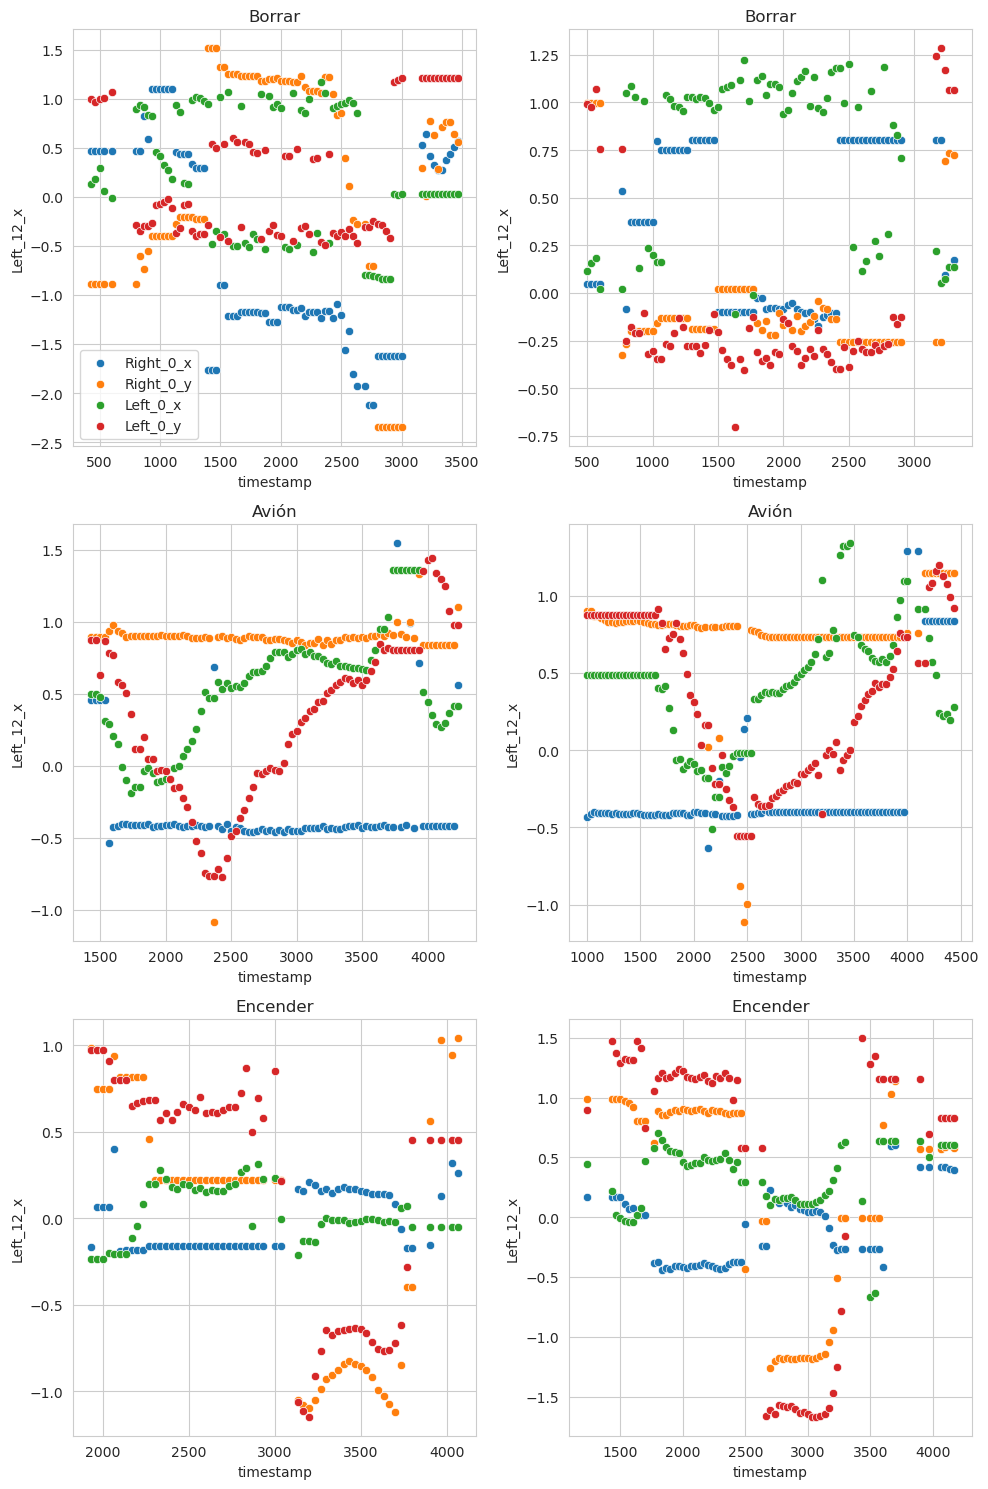

In [87]:
fig, axs = plt.subplots(3, 2, figsize=(10, 15))
show_plot(20, axs[0, 0])
show_plot(16, axs[0, 1])
show_plot(64, axs[1, 0])
show_plot(70, axs[1, 1])
show_plot(85, axs[2, 0])
show_plot(95, axs[2, 1])

axs[0, 0].legend(['Right_0_x', 'Right_0_y', 'Left_0_x', 'Left_0_y'])

plt.tight_layout()

plt.show()


In [95]:
x_train, x_test, y_train, y_test = train_test_split(df['2d_np'], df[df['target'].unique()], test_size=0.3, random_state=42, shuffle=True)

y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

# Convert your lists to NumPy arrays
x_train_list = [np.array(x) for x in x_train.to_list()]
x_test_list = [np.array(x) for x in x_test.to_list()]

# Pad your sequences
x_train_padded = pad_sequences(x_train_list, dtype='float32', padding='post')
x_test_padded = pad_sequences(x_test_list, dtype='float32', padding='post')

# Now, you can stack your arrays
x_train_np = np.stack(x_train_padded)
x_test_np = np.stack(x_test_padded)

In [7]:
model = Sequential()
model.add(LSTM(units=85,
               return_sequences=True,
               activation='tanh',
               ))
model.add(LSTM(units=10,
               return_sequences=True,
               activation='tanh',
               ))
model.add(Dense(units=3,
                activation='relu'))

2024-05-30 16:04:18.011532: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy', 'mse'])

In [9]:
model.fit(x_train_np, y_train_np, epochs=10, batch_size=50, validation_split=0.2)

Epoch 1/10


2024-05-30 16:04:18.580171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-30 16:04:18.582741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-30 16:04:18.584520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

ValueError: in user code:

    File "/home/huerta/.conda/envs/MSLRecognition/lib/python3.8/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/huerta/.conda/envs/MSLRecognition/lib/python3.8/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/huerta/.conda/envs/MSLRecognition/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/huerta/.conda/envs/MSLRecognition/lib/python3.8/site-packages/keras/engine/training.py", line 1055, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/huerta/.conda/envs/MSLRecognition/lib/python3.8/site-packages/keras/engine/training.py", line 1149, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/huerta/.conda/envs/MSLRecognition/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 605, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/huerta/.conda/envs/MSLRecognition/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 77, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/home/huerta/.conda/envs/MSLRecognition/lib/python3.8/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/home/huerta/.conda/envs/MSLRecognition/lib/python3.8/site-packages/keras/metrics/base_metric.py", line 691, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/huerta/.conda/envs/MSLRecognition/lib/python3.8/site-packages/keras/metrics/accuracy_metrics.py", line 459, in sparse_categorical_accuracy
        matches = metrics_utils.sparse_categorical_matches(y_true, y_pred)
    File "/home/huerta/.conda/envs/MSLRecognition/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 971, in sparse_categorical_matches
        matches = tf.cast(tf.equal(y_true, y_pred), backend.floatx())

    ValueError: Dimensions must be equal, but are 3 and 147 for '{{node Equal}} = Equal[T=DT_FLOAT, incompatible_shape_error=true](IteratorGetNext:1, Cast_25)' with input shapes: [?,3], [?,147].


In [109]:
forest = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)
forest.fit(x_train_np, y_train_np)

ValueError: Found array with dim 3. RandomForestClassifier expected <= 2.

In [110]:
rocket = RocketClassifier(num_kernels=1000)
rocket.fit(x_train_np, y_train_np)

RocketClassifier(num_kernels=1000)

In [111]:
rocket_y_pred = rocket.predict(x_test_np)
accuracy_score(y_test_np, rocket_y_pred)

0.8709677419354839

In [113]:
encoder.categories_

[array(['Avión', 'Borrar', 'Encender'], dtype=object)]

In [118]:
encoded

<101x3 sparse matrix of type '<class 'numpy.float64'>'
	with 101 stored elements in Compressed Sparse Row format>

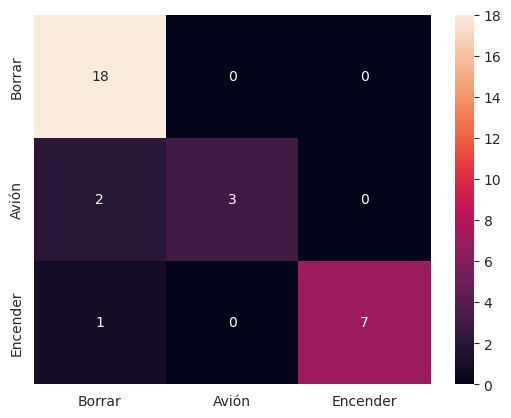

In [124]:
# y_test_np is a 2d array with 3 cols, each col is a one hot encoded label
# show the confusion matrix
cols = ["Borrar", "Avión", "Encender"]
sns.heatmap(confusion_matrix(np.argmax(y_test_np, axis=1), np.argmax(rocket_y_pred, axis=1)), annot=True, xticklabels=cols, yticklabels=cols)
plt.show()

In [122]:
y_test

,Borrar,Avión,Encender
84,0.0,0.0,1.0
55,0.0,1.0,0.0
66,0.0,1.0,0.0
67,0.0,1.0,0.0
45,1.0,0.0,0.0
39,1.0,0.0,0.0
22,1.0,0.0,0.0
44,1.0,0.0,0.0
10,1.0,0.0,0.0
0,1.0,0.0,0.0


In [ ]:
num_classes = df['target'].nunique()
num_classes

In [ ]:
input_shape = x_train_np[0].shape
print(input_shape)
input_layer = keras.layers.Input(input_shape)
conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
conv1 = keras.layers.BatchNormalization()(conv1)
conv1 = keras.layers.Activation('tanh')(conv1)

conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
conv2 = keras.layers.BatchNormalization()(conv2)
conv2 = keras.layers.Activation('tanh')(conv2)

conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
conv3 = keras.layers.BatchNormalization()(conv3)
conv3 = keras.layers.Activation('tanh')(conv3)

gap = keras.layers.GlobalAveragePooling1D()(conv3)

output = keras.layers.Dense(num_classes, activation='softmax')(gap)

keras_model = keras.models.Model(inputs=input_layer, outputs=output)

In [ ]:
epochs = 500
batch_size = 50

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=20,
        min_lr=0.0001,
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=50,
        verbose=1,
    )
]

keras_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['sparse_categorical_accuracy']
)

history = keras_model.fit(
    x_train_np,
    y_train_np,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1
)

In [ ]:
type(x_train_np)

In [ ]:
x_train_np.shape